In [28]:
import os
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import regex as re
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from pickle import dump
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
import pandas as pd

df = pd.read_csv('kickstarter_data_2024.csv')

C:\Users\Philip Nancollas\AppData\Local\Temp\ipykernel_7116\2084980904.py:3: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('kickstarter_data_2024.csv')


In [50]:
# df.head()
# df.info()

In [55]:
cat_data = df['category']
cat_data[100]

'{"id":285,"name":"Plays","analytics_name":"Plays","slug":"theater/plays","position":6,"parent_id":17,"parent_name":"Theater","color":16743775,"urls":{"web":{"discover":"http://www.kickstarter.com/discover/categories/theater/plays"}}}'

In [3]:
nlp_data = df[['blurb', 'state']]

In [4]:
nlp_data['state'].value_counts()

state
successful    1259312
failed         708511
submitted       93425
canceled        88477
live            52881
started          4903
suspended          95
Name: count, dtype: int64

In [5]:
#
nlp_data = nlp_data[nlp_data['state'] != "live"]
nlp_data = nlp_data[nlp_data['state'] != "submitted"]
nlp_data = nlp_data[nlp_data['state'] != "canceled"]
nlp_data = nlp_data[nlp_data['state'] != "started"]
nlp_data = nlp_data[nlp_data['state'] != "suspended"]


In [6]:
nlp_data['state'].value_counts()

state
successful    1259312
failed         708511
Name: count, dtype: int64

In [48]:
nlp_data.head()

,blurb,state
9,"Small knife. Big tasks. No-frills, purpose dri...",successful
10,A beautifully designed stainless steel mirror ...,successful
11,A discreet beverage dispensing and storage sol...,successful
12,Kickstarter exclusive dark mode hardcover & sp...,successful
13,Help us fund the upcoming audiobook by securin...,successful


In [7]:
nlp_data["state"] = nlp_data["state"].apply(lambda x: 1 if x == "successful" else 0).astype(int)
nlp_data['state'].value_counts()


state
1    1259312
0     708511
Name: count, dtype: int64

In [50]:
nlp_data.shape

(1967823, 2)

In [8]:
nlp_data = nlp_data.drop_duplicates()
nlp_data = nlp_data.reset_index(inplace = False, drop = True)
nlp_data.shape
#So many duplicates!

(207225, 2)

In [9]:
nlp_data[nlp_data.select_dtypes(['object']).columns] = nlp_data.select_dtypes(['object']).astype(str)

nlp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207225 entries, 0 to 207224
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   blurb   207225 non-null  object
 1   state   207225 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.2+ MB


In [10]:
def preprocess_text(text):
    # Remove any character that is not a letter (a-z) or white space ( )
    text = re.sub(r'[^a-zA-Z]', " ", text)
    
    # Remove white spaces
    text = re.sub(r'\s+[a-zA-Z]\s+', " ", text)
    text = re.sub(r'\^[a-zA-Z]\s+', " ", text)

    # Multiple white spaces into one
    text = re.sub(r'\s+', " ", text.lower())

    # Remove tags
    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)

    return text.split()

nlp_data["blurb"] = nlp_data["blurb"].apply(preprocess_text)
nlp_data.head()

,blurb,state
0,"[small, knife, big, tasks, no, frills, purpose...",1
1,"[a, beautifully, designed, stainless, steel, m...",1
2,"[a, discreet, beverage, dispensing, and, stora...",1
3,"[kickstarter, exclusive, dark, mode, hardcover...",1
4,"[help, us, fund, the, upcoming, audiobook, by,...",1


In [11]:
download("wordnet")
lemmatizer = WordNetLemmatizer()

download("stopwords")
stop_words = stopwords.words("english")

def lemmatize_text(words, lemmatizer = lemmatizer):
    tokens = [lemmatizer.lemmatize(word) for word in words]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if len(word) > 3]
    return tokens

nlp_data["blurb"] = nlp_data["blurb"].apply(lemmatize_text)
nlp_data.head()

[nltk_data] Downloading package wordnet to C:\Users\Philip
[nltk_data]     Nancollas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Philip
[nltk_data]     Nancollas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,blurb,state
0,"[small, knife, task, frill, purpose, driven, d...",1
1,"[beautifully, designed, stainless, steel, mirr...",1
2,"[discreet, beverage, dispensing, storage, solu...",1
3,"[kickstarter, exclusive, dark, mode, hardcover...",1
4,"[help, fund, upcoming, audiobook, securing, co...",1


In [12]:
nlp_subset = nlp_data.sample(frac=0.1)
nlp_subset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20722 entries, 134049 to 75781
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   blurb   20722 non-null  object
 1   state   20722 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 485.7+ KB


In [13]:
tokens_list = nlp_subset["blurb"] #change if removing subset
tokens_list = [" ".join(tokens) for tokens in tokens_list]

vectorizer = TfidfVectorizer(max_features = 5000, max_df = 0.8, min_df = 5)
X = vectorizer.fit_transform(tokens_list).toarray()
y = nlp_subset["state"]
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [15]:
model = SVC(kernel = "linear", random_state = 42)
model.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [30]:
# dump(model, open("svm_kickstarter_classifier_linear_42.sav", "wb"))

y_pred = model.predict(X_test)
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [31]:
print("Accuracy Score: " + str(accuracy_score(y_test, y_pred)))
print("Precision Score: " + str(precision_score(y_test, y_pred)))
print("Recall Score: " + str(recall_score(y_test, y_pred)))
print("F1 Score: " + str(f1_score(y_test, y_pred)))

Accuracy Score: 0.6752714113389626
Precision Score: 0.7016293279022403
Recall Score: 0.8157063930544594
F1 Score: 0.7543795620437956


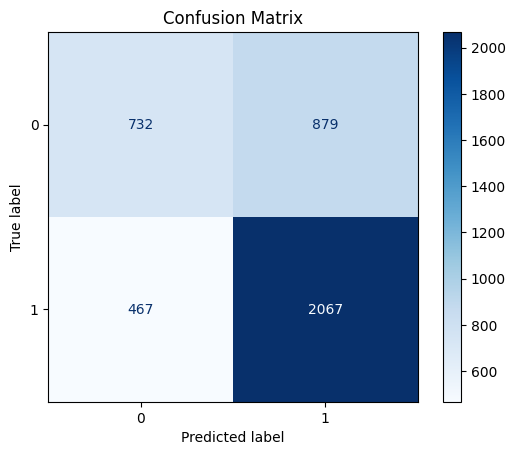

In [18]:
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [19]:
poly_model = SVC(kernel = "poly", random_state = 42)
poly_model.fit(X_train, y_train)

SVC(kernel='poly', random_state=42)

In [32]:
y_pred = poly_model.predict(X_test)
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [33]:
print("Accuracy Score: " + str(accuracy_score(y_test, y_pred)))
print("Precision Score: " + str(precision_score(y_test, y_pred)))
print("Recall Score: " + str(recall_score(y_test, y_pred)))
print("F1 Score: " + str(f1_score(y_test, y_pred)))
# auc (area under the curve)

Accuracy Score: 0.6287092882991556
Precision Score: 0.626172964747654
Recall Score: 0.9743488555643252
F1 Score: 0.762389995368226


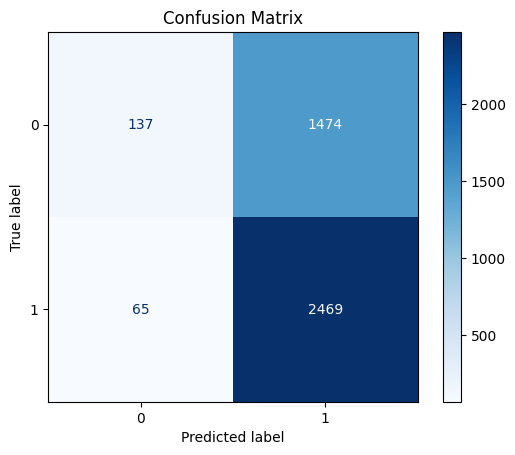

In [34]:
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [31]:
# help(model)
#kernel : {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'}
#gamma : {'scale', 'auto'}


In [36]:
rbf_model = SVC(kernel = "rbf", random_state = 42)
rbf_model.fit(X_train, y_train)
#We have a winner! (0.689) --Still the best after tuning

SVC(random_state=42)

In [37]:
y_pred = rbf_model.predict(X_test)
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [38]:
print("Accuracy Score: " + str(accuracy_score(y_test, y_pred)))
print("Precision Score: " + str(precision_score(y_test, y_pred)))
print("Recall Score: " + str(recall_score(y_test, y_pred)))
print("F1 Score: " + str(f1_score(y_test, y_pred)))

Accuracy Score: 0.6822677925211098
Precision Score: 0.6929908024104028
Recall Score: 0.8622730860299921
F1 Score: 0.7684192016880604


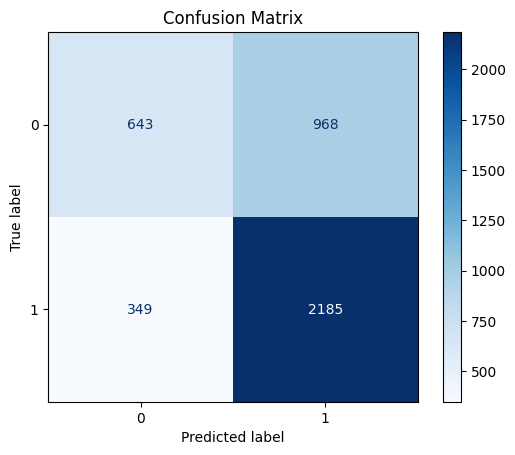

In [39]:
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [27]:
sig_model = SVC(kernel = "sigmoid", random_state = 42)
sig_model.fit(X_train, y_train)

SVC(kernel='sigmoid', random_state=42)

In [28]:
y_pred = sig_model.predict(X_test)
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [29]:
accuracy_score(y_test, y_pred)

0.6837153196622436

In [40]:
rbfa_model = SVC(kernel = "rbf", gamma="auto", random_state = 42)
rbfa_model.fit(X_train, y_train)

SVC(gamma='auto', random_state=42)

In [41]:
y_pred = rbfa_model.predict(X_test)
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [42]:
print("Accuracy Score: " + str(accuracy_score(y_test, y_pred)))
print("Precision Score: " + str(precision_score(y_test, y_pred)))
print("Recall Score: " + str(recall_score(y_test, y_pred)))
print("F1 Score: " + str(f1_score(y_test, y_pred)))

Accuracy Score: 0.6113389626055489
Precision Score: 0.6113389626055489
Recall Score: 1.0
F1 Score: 0.7587962269800869


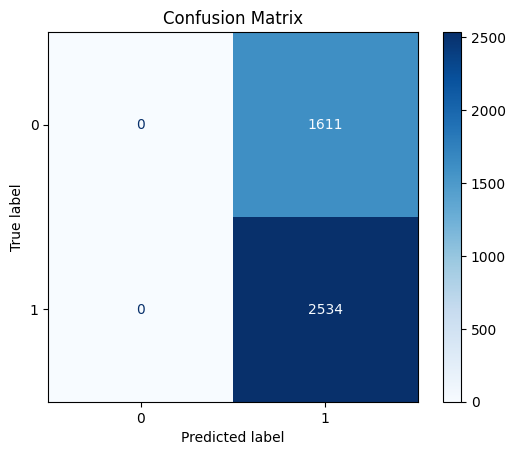

In [ ]:
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

#It's a null model lol

In [44]:
nlp_success_set = nlp_data[nlp_data['state'] == 1]
nlp_failed_set = nlp_data[nlp_data['state'] == 0]


In [47]:
print(nlp_failed_set['blurb'])

51        [comedy, interactive, short, movie, covid, ple...
52        [caribbean, american, sitcom, enlighten, audie...
53        [short, film, inspired, real, life, former, mo...
54        [project, friend, created, high, school, four,...
55                                             [fred, marv]
                                ...                        
206466    [timing, chain, conversion, designed, replace,...
206501    [innovative, universal, controller, whose, plu...
206524    [developing, reliable, highly, accurate, liqui...
206525    [designed, elderly, physically, challenged, ca...
206653    [taiko, drum, controller, high, sensitivity, n...
Name: blurb, Length: 80176, dtype: object


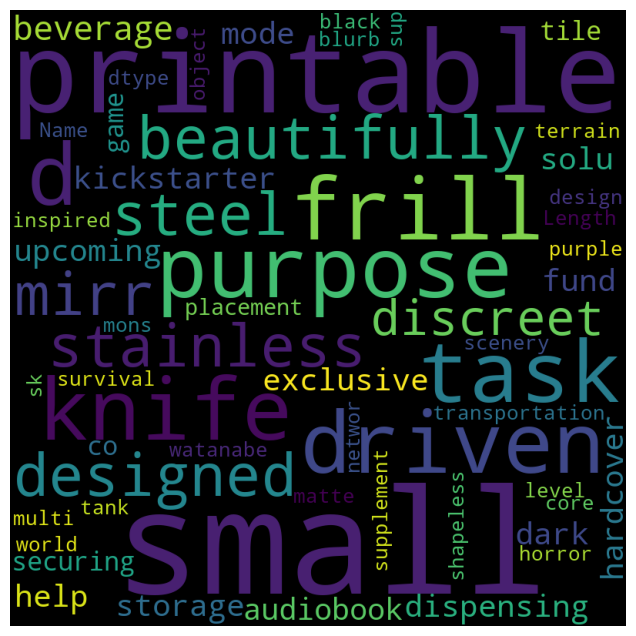

In [48]:
from wordcloud import WordCloud

success_wordcloud = WordCloud(width = 800, height = 800, background_color = "black", max_words = 10000, min_font_size = 20, random_state = 42)\
    .generate(str(nlp_success_set["blurb"]))

fig = plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(success_wordcloud)
plt.axis("off")
plt.show()

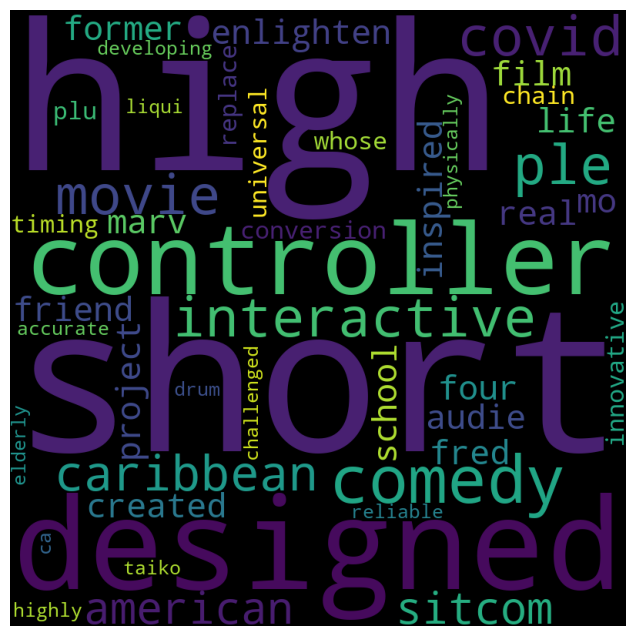

In [46]:
fail_wordcloud = WordCloud(width = 800, height = 800, background_color = "black", max_words = 1000, min_font_size = 20, random_state = 42)\
    .generate(str(nlp_failed_set["blurb"]))

fig = plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(fail_wordcloud)
plt.axis("off")
plt.show()

In [46]:
nlp_big_subset = nlp_data.sample(frac=0.3)
nlp_big_subset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62168 entries, 126494 to 132240
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   blurb   62168 non-null  object
 1   state   62168 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ MB


In [47]:
tokens_list = nlp_big_subset["blurb"] #change if removing subset
tokens_list = [" ".join(tokens) for tokens in tokens_list]

vectorizer = TfidfVectorizer(max_features = 5000, max_df = 0.8, min_df = 5)
X = vectorizer.fit_transform(tokens_list).toarray()
y = nlp_big_subset["state"]
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
# Run this later, it will probably take ~10 hrs
rbf_model = SVC(kernel = "rbf", random_state = 42)
rbf_model.fit(X_train, y_train)

In [44]:
y_pred = rbf_model.predict(X_test)
y_pred

array([1, 0, 1, ..., 1, 1, 1])

In [45]:
accuracy_score(y_test, y_pred)

0.6981541802388708